# ***Data Processing***

## Import Required Libs

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from underthesea import word_tokenize
import re
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
import requests
import random
import cloudpickle

## Load Raw Data

### UIT-VSFC

In [ ]:
def load_txt(file_path):
    with open(file_path, 'r', encoding='utf-8') as inp:
        return [line.strip() for line in inp.readlines()]

def load_vsfc(folder_path):
    sentiments = load_txt(f'{folder_path}/sentiments.txt')
    topics = load_txt(f'{folder_path}/topics.txt')
    sents = load_txt(f'{folder_path}/sents.txt')
    return pd.DataFrame({
        'sent': pd.Series(sents, dtype=str),
        'topic': pd.Series(topics, dtype='int32'),
        'sentiment': pd.Series(sentiments, dtype='int32')
    })

In [ ]:
vsfc_train_df = load_vsfc('../data/raw/uit-vsfc/train')
vsfc_valid_df = load_vsfc('../data/raw/uit-vsfc/dev')
vsfc_test_df = load_vsfc('../data/raw/uit-vsfc/test')

In [ ]:
vsfc_train_df.head()

,sent,topic,sentiment
0,slide giáo trình đầy đủ .,1,2
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",0,2
2,đi học đầy đủ full điểm chuyên cần .,1,0
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",0,2


In [ ]:
print(f'Train length: {len(vsfc_train_df)}')
print(f'Valid length: {len(vsfc_valid_df)}')
print(f'Test length: {len(vsfc_test_df)}')

Train length: 11426
Valid length: 1583
Test length: 3166


In [ ]:
print('Train:')
print(vsfc_train_df.isna().sum())
print('-' * 50)
print('Valid:')
print(vsfc_valid_df.isna().sum())
print('-' * 50)
print('Test:')
print(vsfc_test_df.isna().sum())

Train:
sent         0
topic        0
sentiment    0
dtype: int64
--------------------------------------------------
Valid:
sent         0
topic        0
sentiment    0
dtype: int64
--------------------------------------------------
Test:
sent         0
topic        0
sentiment    0
dtype: int64


In [ ]:
def fix_label_vsfc(df):
    df['sentiment'] = df['sentiment'].apply(lambda x: ('NEG', 'NEU', 'POS')[x])
    df.drop(columns=['topic'], inplace=True)
    return df

In [ ]:
vsfc_train_df = fix_label_vsfc(vsfc_train_df)
vsfc_valid_df = fix_label_vsfc(vsfc_valid_df)
vsfc_test_df = fix_label_vsfc(vsfc_test_df)

In [ ]:
vsfc_train_df.head()

,sent,sentiment
0,slide giáo trình đầy đủ .,POS
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",POS
2,đi học đầy đủ full điểm chuyên cần .,NEG
3,chưa áp dụng công nghệ thông tin và các thiết ...,NEG
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",POS


### Tiki

In [ ]:
tiki_df = pd.read_csv('../data/raw/tiki/comments.csv')

In [ ]:
tiki_df.head()

,product_id,comment_id,title,thank_count,customer_id,rating,content
0,74021317,12559756,Cực kì hài lòng,313,22051463,5,"Có những người bước đến, họ lấp đầy hạnh phúc ..."
1,74021317,16979365,Cực kì hài lòng,6,27791831,5,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ..."
2,74021317,14069617,Cực kì hài lòng,25,17748750,5,"Bìa cực xinh, tiki giao hàng nhanh, sách không..."
3,74021317,8569824,Cực kì hài lòng,57,410797,5,"Sách lúc nhận hình thức rất ổn, không cong vên..."
4,74021317,18368714,Cực kì hài lòng,0,28545286,5,Một cuốn sách rất đáng đọc về tình yêu thương ...


In [ ]:
tiki_df.isna().sum()

,0
product_id,0
comment_id,0
title,4
thank_count,0
customer_id,0
rating,0
content,38018


In [ ]:
tiki_df = tiki_df.loc[(tiki_df['content'].notna()) | (tiki_df['content'].str.strip() == '')]

In [ ]:
len(tiki_df)

103263

In [ ]:
tiki_df['sentiment'] = tiki_df['rating'].apply(lambda x: ('NEG', 'NEG', 'NEU', 'POS', 'POS')[x - 1])
tiki_df.rename(columns={
    'content': 'sent'
}, inplace=True)
tiki_df = tiki_df[['sent', 'sentiment']]

In [ ]:
tiki_df.head()

,sent,sentiment
0,"Có những người bước đến, họ lấp đầy hạnh phúc ...",POS
1,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ...",POS
2,"Bìa cực xinh, tiki giao hàng nhanh, sách không...",POS
3,"Sách lúc nhận hình thức rất ổn, không cong vên...",POS
4,Một cuốn sách rất đáng đọc về tình yêu thương ...,POS


In [ ]:
tiki_train_df, tiki_valid_test_df = train_test_split(tiki_df, test_size=0.2, random_state=42, stratify=tiki_df['sentiment'])
tiki_valid_df, tiki_test_df = train_test_split(tiki_valid_test_df, test_size=0.5, random_state=42, stratify=tiki_valid_test_df['sentiment'])

### UIT-VSMEC

In [ ]:
vsmec_train_df = pd.read_excel('../data/raw/uit-vsmec/train_nor_811.xlsx')
vsmec_valid_df = pd.read_excel('../data/raw/uit-vsmec/valid_nor_811.xlsx')
vsmec_test_df = pd.read_excel('../data/raw/uit-vsmec/test_nor_811.xlsx')

In [ ]:
vsmec_train_df.head()

,Unnamed: 0,Emotion,Sentence
0,188,Other,cho mình xin bài nhạc tên là gì với ạ
1,166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...
3,316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :))
4,1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...


In [ ]:
print(f'Train: \n{vsmec_train_df.isna().sum()}')
print('-' * 50)
print(f'Valid: \n{vsmec_valid_df.isna().sum()}')
print('-' * 50)
print(f'Test: \n{vsmec_test_df.isna().sum()}')

Train: 
Unnamed: 0    0
Emotion       0
Sentence      0
dtype: int64
--------------------------------------------------
Valid: 
Unnamed: 0    0
Emotion       0
Sentence      0
dtype: int64
--------------------------------------------------
Test: 
Unnamed: 0    0
Emotion       0
Sentence      0
dtype: int64


In [ ]:
print(f'Train length: {len(vsmec_train_df)}')
print(f'Valid length: {len(vsmec_valid_df)}')
print(f'Test length: {len(vsmec_test_df)}')

Train length: 5548
Valid length: 686
Test length: 693


In [ ]:
vsmec_train_df['Emotion'].unique()

array(['Other', 'Disgust', 'Enjoyment', 'Anger', 'Surprise', 'Sadness',
       'Fear'], dtype=object)

In [ ]:
def emotion_to_sentiment(emotion):
    pos = ['Enjoyment']
    neg = ['Disgust', 'Anger', 'Sadness', 'Fear']
    neu = ['Other', 'Surprise']
    if emotion in pos:
        return 'POS'
    elif emotion in neg:
        return 'NEG'
    return 'NEU'
def fix_vsmec_df(df):
    df['sentiment'] = df['Emotion'].apply(emotion_to_sentiment)
    df.rename(columns={
        'Sentence': 'sent'
    }, inplace=True)
    df = df[['sent', 'sentiment']]
    return df

In [ ]:
vsmec_train_df = fix_vsmec_df(vsmec_train_df)
vsmec_valid_df = fix_vsmec_df(vsmec_valid_df)
vsmec_test_df = fix_vsmec_df(vsmec_test_df)

In [ ]:
vsmec_train_df.head()

,sent,sentiment
0,cho mình xin bài nhạc tên là gì với ạ,NEU
1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,NEG
2,lo học đi . yêu đương lol gì hay lại thích học...,NEG
3,uớc gì sau này về già vẫn có thể như cụ này :)),POS
4,mỗi lần có video của con là cứ coi đi coi lại ...,POS


### IMDB

In [ ]:
imdb_df = pd.read_csv('../data/raw/imdb/VI_IMDB.csv')

In [ ]:
imdb_df.head()

,review,sentiment,vi_review
0,One of the other reviewers has mentioned that ...,positive,Một trong những người đánh giá khác đã đề cập ...
1,A wonderful little production. <br /><br />The...,positive,Một sản phẩm nhỏ tuyệt vời. <br /><br />Kỹ thu...
2,I thought this was a wonderful way to spend ti...,positive,Tôi nghĩ đây là một cách tuyệt vời để dành thờ...
3,Basically there's a family where a little boy ...,negative,"Về cơ bản, có một gia đình mà một cậu bé (Jake..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"""Love in the Time of Money"" của Petter Mattei ..."


In [ ]:
imdb_df.isna().sum()

,0
review,0
sentiment,0
vi_review,0


In [ ]:
len(imdb_df)

50000

In [ ]:
def fix_sentiment(sentiment):
    if sentiment == 'positive':
        return 'POS'
    elif sentiment == 'negative':
        return 'NEG'
    return 'NEU'

In [ ]:
imdb_df['sentiment'] = imdb_df['sentiment'].apply(fix_sentiment)
imdb_df.rename(columns={
    'vi_review': 'sent'
}, inplace=True)
imdb_df = imdb_df[['sent', 'sentiment']]

In [ ]:
imdb_df.head()

,sent,sentiment
0,Một trong những người đánh giá khác đã đề cập ...,POS
1,Một sản phẩm nhỏ tuyệt vời. <br /><br />Kỹ thu...,POS
2,Tôi nghĩ đây là một cách tuyệt vời để dành thờ...,POS
3,"Về cơ bản, có một gia đình mà một cậu bé (Jake...",NEG
4,"""Love in the Time of Money"" của Petter Mattei ...",POS


In [ ]:
imdb_train_df, imdb_valid_test_df = train_test_split(imdb_df, test_size=0.2, random_state=42, stratify=imdb_df['sentiment'])
imdb_valid_df, imdb_test_df = train_test_split(imdb_valid_test_df, test_size=0.5, random_state=42, stratify=imdb_valid_test_df['sentiment'])

### UIT-VISFD

In [ ]:
visfd_train_df = pd.read_csv('../data/raw/uit-visfd/Train.csv')
visfd_valid_df = pd.read_csv('../data/raw/uit-visfd/Dev.csv')
visfd_test_df = pd.read_csv('../data/raw/uit-visfd/Test.csv')

In [ ]:
visfd_train_df.head()

,index,comment,n_star,date_time,label
0,0,Mới mua máy này Tại thegioididong thốt nốt cảm...,5,2 tuần trước,{CAMERA#Positive};{FEATURES#Positive};{BATTERY...
1,1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,5,14/09/2019,{BATTERY#Negative};{GENERAL#Positive};{OTHERS};
2,2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,3,17/08/2020,{FEATURES#Negative};
3,3,"Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...",3,29/02/2020,{FEATURES#Negative};{BATTERY#Neutral};{GENERAL...
4,4,"Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...",5,4/6/2020,{BATTERY#Positive};{PERFORMANCE#Positive};{SER...


In [ ]:
print(f'Train: \n{visfd_train_df.isna().sum()}')
print('-' * 50)
print(f'Valid: \n{visfd_valid_df.isna().sum()}')
print('-' * 50)
print(f'Test: \n{visfd_test_df.isna().sum()}')

Train: 
index        0
comment      0
n_star       0
date_time    0
label        0
dtype: int64
--------------------------------------------------
Valid: 
index        0
comment      0
n_star       0
date_time    0
label        0
dtype: int64
--------------------------------------------------
Test: 
index        0
comment      0
n_star       0
date_time    0
label        0
dtype: int64


In [ ]:
print(f'Train length: {len(visfd_train_df)}')
print(f'Valid length: {len(visfd_valid_df)}')
print(f'Test length: {len(visfd_test_df)}')

Train length: 7786
Valid length: 1112
Test length: 2224


In [ ]:
def label_to_sentiment(label):
    tags = label.split(';')
    if not tags:
        return 'NEU'
    count_pos = 0
    for tag in tags:
        if len(tag) < 2:
            continue
        tag = tag[1:-1]
        parts = tag.split('#')
        if len(parts) != 2:
            continue
        feature, sentiment = parts
        if sentiment == 'Positive':
            sentiment = 'POS'
        elif sentiment == 'Negative':
            sentiment = 'NEG'
        else:
            sentiment = 'NEU'
        if feature == 'GENERAL':
            return sentiment
        if sentiment == 'POS':
            count_pos += 1
        elif sentiment == 'NEG':
            count_pos -= 1
    if count_pos > 0:
        return 'POS'
    elif count_pos < 0:
        return 'NEG'
    return 'NEU'
tests = [
    '{FEATURES#Negative};',
    '{BATTERY#Negative};{GENERAL#Positive};{OTHERS};',
    '{BATTERY#Negative};{FEATURES#Positive};{OTHERS};'
]
print([label_to_sentiment(test) for test in tests])

['NEG', 'POS', 'NEU']


In [ ]:
def fix_visfd_df(df):
    df['sentiment'] = df['label'].apply(label_to_sentiment)
    df.rename(columns={
        'comment': 'sent'
    }, inplace=True)
    df = df[['sent', 'sentiment']]
    return df

In [ ]:
visfd_train_df = fix_visfd_df(visfd_train_df)
visfd_valid_df = fix_visfd_df(visfd_valid_df)
visfd_test_df = fix_visfd_df(visfd_test_df)

In [ ]:
visfd_train_df.head()

,sent,sentiment
0,Mới mua máy này Tại thegioididong thốt nốt cảm...,POS
1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,POS
2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,NEG
3,"Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...",NEU
4,"Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...",POS


### Cat all datasets

In [ ]:
train_df = pd.concat([vsfc_train_df, tiki_train_df, vsmec_train_df, imdb_train_df, visfd_train_df], ignore_index=True)
valid_df = pd.concat([vsfc_valid_df, tiki_valid_df, vsmec_valid_df, imdb_valid_df, visfd_valid_df], ignore_index=True)
test_df = pd.concat([vsfc_test_df, tiki_test_df, vsmec_test_df, imdb_test_df, visfd_test_df], ignore_index=True)

In [ ]:
print(f'Train length: {len(train_df)}')
print(f'Valid length: {len(valid_df)}')
print(f'Test length: {len(test_df)}')

Train length: 147370
Valid length: 18707
Test length: 21410


## Clean data

In [ ]:
def clean_text(text):
    text = text.lower()
    text = BeautifulSoup(text, 'html.parser').get_text(separator=' ')
    text = re.sub(r"[‘’`]", "'", text)
    text = re.sub(r"[“”]", '"', text)
    text = re.sub(r"[–—−]", "-", text)
    text = re.sub(r'(.)\1+', r'\1', text)
    emoji_groups = {
        "<happy>": ["🙂", "😊", "😄", "😁", "😃", ":)", ":-)", ":d", ":-d", ":p", ":v", "=)", "colonsmile", "colonsmilesmile", ":3", "coloncontemn", "colonbigsmile", "colonsmallsmile", "colonhihi"],
        "<love>":  ["😍", "❤️", "💕", "💖", "<3", "colonlove", ":\">", "colonlovelove"],
        "<sad>":   ["😢", "😭", "☹️", "🙁", ":(", ":-(", "=(", "colonsad", ":_", "coloncc", ":'(", "colonsadcolon",],
        "<angry>": ["😡", "🤬", "😠"],
        "<surprise>": ["😲", "😮", "😯", "😳", "colonsurprise", ":@", "colondoublesurprise"],
        "<thinking>": ["🤔"],
        "<neutral>": ["😐", "😑", "coloncolon"]
    }
    for key, icons in emoji_groups.items():
        for icon in icons:
            text = text.replace(icon, f' {key} ')
    text = text.replace('doubledot', ':')
    text = text.replace('vdotv', '.')
    text = text.replace('v.v', '.')
    text = text.replace('dotdotdot', '.')
    text = text.replace('fraction', '/')
    text = re.sub(r"[^a-zA-Z0-9À-ỹ\s.,;:-<>/()!?'\"-]", " ", text)
    for punc in '.,;:\'"()!-?/<>':
        text = text.replace(punc, f' {punc} ')
    text = word_tokenize(text, format='text')
    text = re.sub(r"<[_\s]happy[_\s]>", "<happy>", text)
    text = re.sub(r"<[_\s]love[_\s]>", "<love>", text)
    text = re.sub(r"<[_\s]sad[_\s]>", "<sad>", text)
    text = re.sub(r"<[_\s]angry[_\s]>", "<angry>", text)
    text = re.sub(r"<[_\s]surprise[_\s]>", "<surprise>", text)
    text = re.sub(r"<[_\s]thinking[_\s]>", "<thinking>", text)
    text = re.sub(r"<[_\s]neutral[_\s]>", "<neutral>", text)
    text = re.sub('\s+', ' ', text).strip()
    return text

test_sentences = [
    "hj <p>hôm<p> nay đi chơi vui vc :)) 😄",
    "Tôi ko muốn đi học hôm nay :(( 😢",
    "Anh iu em lắm ❤️ 😍",
    "Vc quá, sao mày làm thế 😡 🤬",
    "Wow 😮, thật là bất ngờ 🤔"
]

for sent in test_sentences:
    print(f'Origin: {sent}')
    print(f'Cleaned: {clean_text(sent)}')
    print('-' * 50)

Origin: hj <p>hôm<p> nay đi chơi vui vc :)) 😄
Cleaned: hj hôm_nay đi chơi vui_vc <happy> <happy>
--------------------------------------------------
Origin: Tôi ko muốn đi học hôm nay :(( 😢
Cleaned: tôi ko muốn đi học hôm_nay <sad> <sad>
--------------------------------------------------
Origin: Anh iu em lắm ❤️ 😍
Cleaned: anh iu em lắm <love> <love>
--------------------------------------------------
Origin: Vc quá, sao mày làm thế 😡 🤬
Cleaned: vc quá , sao mày làm thế <angry> <angry>
--------------------------------------------------
Origin: Wow 😮, thật là bất ngờ 🤔
Cleaned: wow <surprise> , thật là bất_ngờ <thinking>
--------------------------------------------------


In [ ]:
train_df['sent'] = train_df['sent'].apply(clean_text)
valid_df['sent'] = valid_df['sent'].apply(clean_text)
test_df['sent'] = test_df['sent'].apply(clean_text)

## EDA

### Sentiment Label Distribution

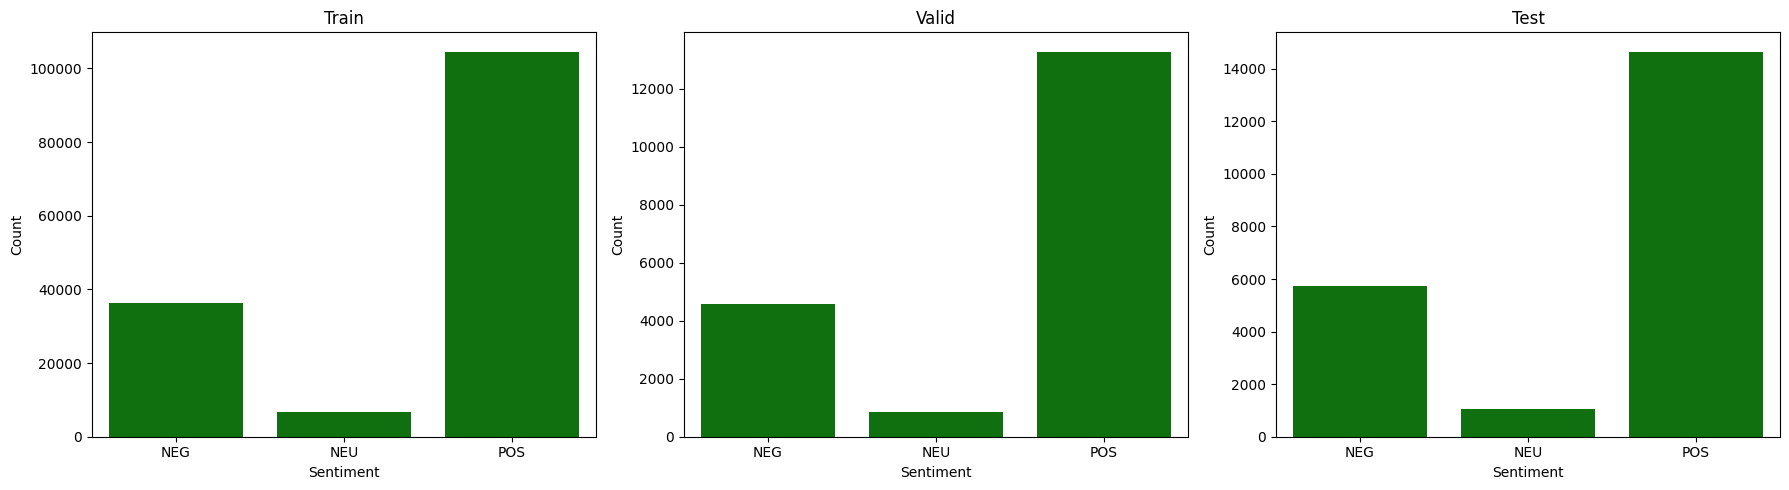

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

order = sorted(train_df['sentiment'].unique())

sns.countplot(x='sentiment', data=train_df, order=order, color='green', ax=axes[0])
axes[0].set_title('Train')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')

sns.countplot(x='sentiment', data=valid_df, order=order, color='green', ax=axes[1])
axes[1].set_title('Valid')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')

sns.countplot(x='sentiment', data=test_df, order=order, color='green', ax=axes[2])
axes[2].set_title('Test')
axes[2].set_xlabel('Sentiment')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Length Sentence Distribution

In [ ]:
train_sent_lengths = train_df['sent'].apply(lambda x: len(x.split()))
valid_sent_lengths = valid_df['sent'].apply(lambda x: len(x.split()))
test_sent_lengths = test_df['sent'].apply(lambda x: len(x.split()))

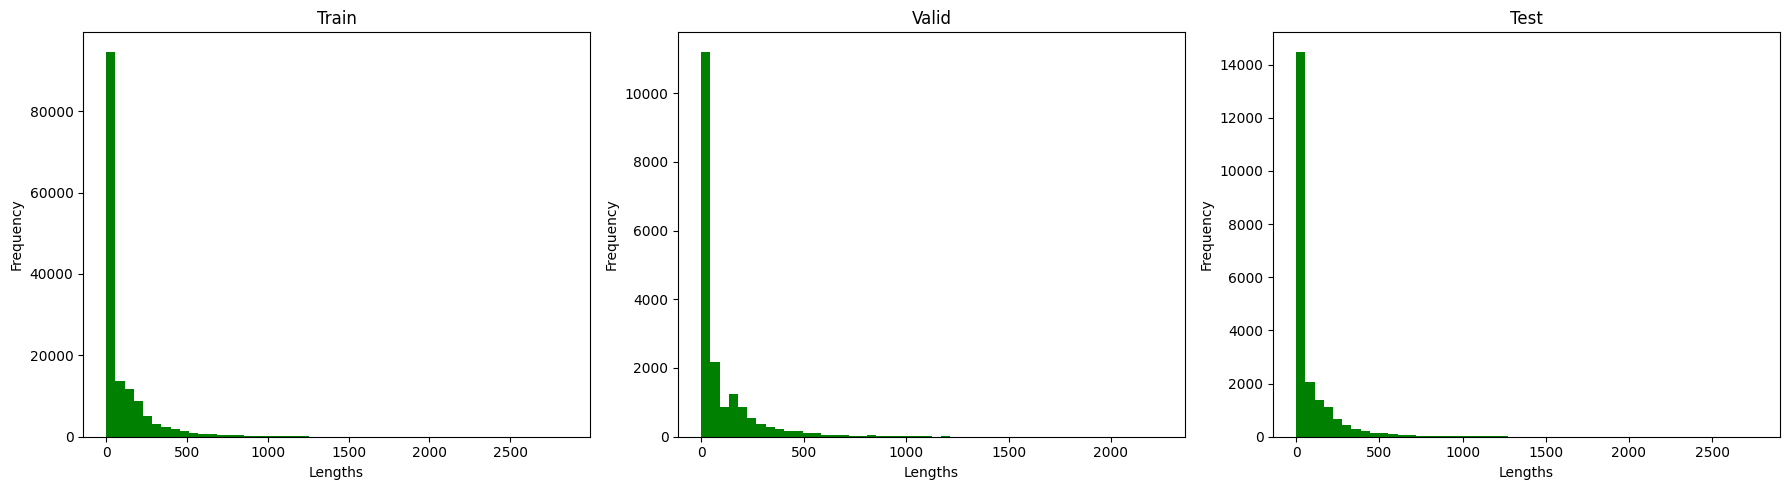

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(train_sent_lengths, bins=50, color='green')
axes[0].set_title('Train')
axes[0].set_xlabel('Lengths')
axes[0].set_ylabel('Frequency')

axes[1].hist(valid_sent_lengths, bins=50, color='green')
axes[1].set_title('Valid')
axes[1].set_xlabel('Lengths')
axes[1].set_ylabel('Frequency')

axes[2].hist(test_sent_lengths, bins=50, color='green')
axes[2].set_title('Test')
axes[2].set_xlabel('Lengths')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Data Augmentation

### Back Translation

In [19]:
def make_link(text, src_code, dst_code):
    text_encoded = urllib.parse.quote(text)
    url = f"https://clients5.google.com/translate_a/t?client=dict-chrome-ex&sl={src_code}&tl={dst_code}&dt=t&q={text_encoded}"
    return url
link = make_link('khó', 'vi', 'en')
print(link)
print(len(link))

https://clients5.google.com/translate_a/t?client=dict-chrome-ex&sl=vi&tl=en&dt=t&q=kh%C3%B3
91


In [ ]:
res = requests.get('https://clients5.google.com/translate_a/t?client=dict-chrome-ex&sl=vi&tl=en&dt=t&q=kh%C3%B3')
print(res.json())

['difficult']


In [ ]:
def extract_json(json):
    if not isinstance(json, list):
        return None
    item = json[0]
    if isinstance(item, str):
        return item
    if not isinstance(item, list):
        return None
    text = item[0]
    if not isinstance(text, str):
        return None
    return text

def back_translate(lang_code, sent):
    try:
        sent = sent.replace('_', ' ') \
            .replace('<happy>', '<_h_>') \
            .replace('<love>', '<_l_>') \
            .replace('<sad>', '<_s_>')  \
            .replace('<angry>', '<_a_>')  \
            .replace('<surprise>', '<_sp_>')  \
            .replace('<thinking>', '<_t_>') \
            .replace('<neutral>', '<_n_>')
        forward_api = make_link(sent, 'vi', lang_code)
        forward_res = requests.get(forward_api)
        forward_json = forward_res.json()
        translated_text = extract_json(forward_json)
        if not translated_text:
            return None

        backward_api = make_link(translated_text, lang_code, 'vi')
        backward_res = requests.get(backward_api)
        backward_json = backward_res.json()
        aug_sent = extract_json(backward_json)
        if not aug_sent:
            return None

        aug_sent = aug_sent.replace('<_h_>', '<happy>') \
            .replace('<_l_>', '<love>') \
            .replace('<_s_>', '<sad>')  \
            .replace('<_a_>', '<angry>')  \
            .replace('<_sp_>', '<surprise>')  \
            .replace('<_t_>', '<thinking>') \
            .replace('<_n_>', '<neutral>')
        aug_sent = word_tokenize(aug_sent, format='text')
        aug_sent = re.sub(r"<[_\s]happy[_\s]>", "<happy>", aug_sent)
        aug_sent = re.sub(r"<[_\s]love[_\s]>", "<love>", aug_sent)
        aug_sent = re.sub(r"<[_\s]sad[_\s]>", "<sad>", aug_sent)
        aug_sent = re.sub(r"<[_\s]angry[_\s]>", "<angry>", aug_sent)
        aug_sent = re.sub(r"<[_\s]surprise[_\s]>", "<surprise>", aug_sent)
        aug_sent = re.sub(r"<[_\s]thinking[_\s]>", "<thinking>", aug_sent)
        aug_sent = re.sub(r"<[_\s]neutral[_\s]>", "<neutral>", aug_sent)
        return aug_sent

    except Exception as e:
        print(e)
        return None

In [ ]:
back_translate('en', 'Tôi cô đơn quá')

'Tôi rất cô_đơn'

In [24]:
def aug_back_translate(sent, num_languages, percent_aug):
    if random.random() > percent_aug:
        return []
    aug_sents = []
    codes = ["en", "fr", "de", "es", "pt", "it", "nl", "sv", "no", "da", "ru", "pl", "cs", "hu", "tr", "ar", "hi", "zh", "ja", "ko"]
    for code in random.sample(codes, num_languages):
        aug_sents.append(back_translate(code, sent))
    return aug_sents

In [26]:
def neu_aug_back_translate(x):
    return aug_back_translate(x, 6, 1)
def neg_aug_back_translate(x):
    return aug_back_translate(x, 2, 0.4)

def make_runner(func):
    pickled_func = cloudpickle.dumps(func)
    def runner(v):
        import cloudpickle
        return cloudpickle.loads(pickled_func)(v)
    return runner

In [ ]:
pandarallel.initialize(progress_bar=True, nb_workers=16)

neu_aug = train_df.loc[train_df['sentiment'] == 'NEU', 'sent'].parallel_apply(make_runner(neu_aug_back_translate)).tolist()
flat_neu_aug = []
for item in neu_aug:
    if item:
        flat_neu_aug.extend(item)
neu_aug_df = pd.DataFrame({
    'sent': pd.Series(flat_neu_aug, dtype=str),
    'sentiment': pd.Series(['AUG_NEU'] * len(flat_neu_aug), dtype=str)
})
train_df = pd.concat([train_df, neu_aug_df], ignore_index=True)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [ ]:
neg_aug = train_df.loc[train_df['sentiment'] == 'NEG', 'sent'].parallel_apply(make_runner(neg_aug_back_translate)).tolist()
flat_neg_aug = []
for item in neg_aug:
    flat_neg_aug.extend(item)
neg_aug_df = pd.DataFrame({
    'sent': pd.Series(flat_neg_aug, dtype=str),
    'sentiment': pd.Series(['AUG_NEG'] * len(flat_neg_aug), dtype=str)
})
train_df = pd.concat([train_df, neg_aug_df], ignore_index=True)

Text(0, 0.5, 'Count')

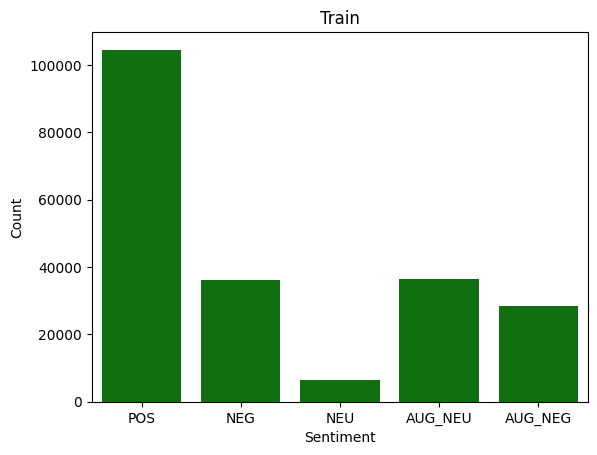

In [ ]:
ax = sns.countplot(x='sentiment', data=train_df, color='green')
ax.set_title('Train')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')

### Oversampling

In [63]:
neu_df = train_df[train_df['sentiment'] == 'NEU']
neu_oversampled = neu_df.sample(len(neu_df) * 2, replace=True, random_state=42)

In [65]:
neg_df = train_df[train_df['sentiment'] == 'NEG']
neg_oversampled = neg_df.sample(len(neg_df) // 3, replace=True, random_state=42)

In [66]:
train_df = pd.concat([train_df, neu_oversampled, neg_oversampled], ignore_index=True)
train_df.loc[train_df['sentiment'] == 'AUG_NEU', 'sentiment'] = 'NEU'
train_df.loc[train_df['sentiment'] == 'AUG_NEG', 'sentiment'] = 'NEG'

### New Distribution

Text(0, 0.5, 'Count')

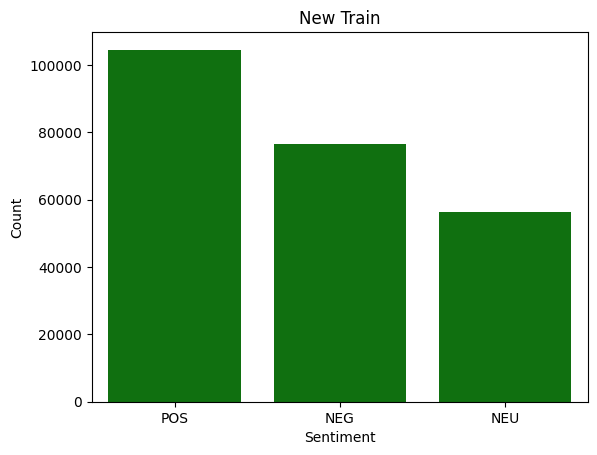

In [67]:
ax = sns.countplot(x='sentiment', data=train_df, color='green')
ax.set_title('New Train')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')

In [ ]:
train_df.to_csv('../data/processed/train.csv')
valid_df.to_csv('../data/processed/valid.csv')
test_df.to_csv('../data/processed/test.csv')